In [2]:
import numpy as np # linear algebra
import pandas as pd
import os
import json
import re, string
import sys
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import optimize

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def init_ds(json):
    ds= {}
    keys = json.keys()
    for k in keys:
        ds[k]= []
    return ds, keys

def read_json(file):
    dataset = {}
    keys = []
    with open(file) as file_lines:
        for count, line in enumerate(file_lines):
            data = json.loads(line.strip())
            if count ==0:
                dataset, keys = init_ds(data)
            for k in keys:
                dataset[k].append(data[k])
                
        return pd.DataFrame(dataset)

In [4]:
yelp_review = read_json("/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json")
# yelp_review["date"] = pd.to_datetime(yelp_review["date"], format = "%Y-%m-%d")

In [7]:
def tokenize(s):
    """Convert string to lowercase and split into words (ignoring
    punctuation), returning list of words.
    """
    word_list = re.findall(r'\w+', s.lower())
    filtered_words = [word for word in word_list]
    return filtered_words


def count_ngrams(lines, min_length=1, max_length=1):
    lengths = range(min_length, max_length + 1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen=max_length)

    # Helper function to add n-grams at start of current queue to dict
    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current) >= length:
                ngrams[length][current[:length]] += 1

    # Loop through all lines and words and add n-grams to dict
    for line in lines:
        for word in tokenize(line):
            queue.append(word)
            if len(queue) >= max_length:
                add_queue()

    while len(queue) > min_length:
        queue.popleft()
        add_queue()

    return ngrams

## Gaussian fit

In [8]:
doc = yelp_review.text[0:10000]
review_length = []
for line in doc:
    words = tokenize(line)
#     print(words)
    review_length.append(len(words))
# print(review_length)

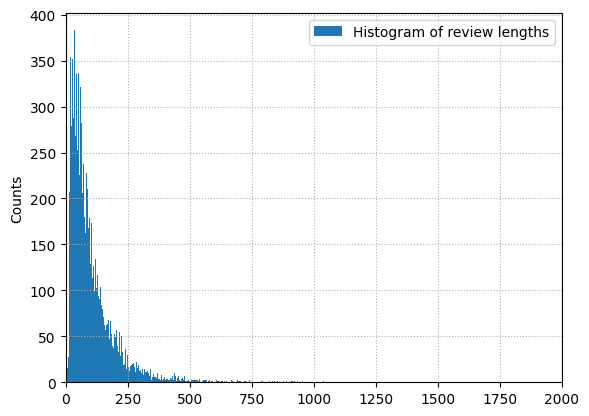

In [80]:
bins = 300

fig1, ax1 = plt.subplots()
#ax1.set_axisbelow(True)
ax1.set_xlim(0,2000)
(counts1,edges1, patches1) = plt.hist(review_length, bins, label="Histogram of review lengths")
plt.ylabel("Counts")
plt.legend(loc = 'upper right')
plt.grid(linestyle=':')
plt.show()

# plt.hist(review_length, bins = 200)
# plt.savefig("02.review.length.pdf", format="pdf", bbox_inches="tight") 

In [81]:
mean = np.mean(review_length) 
sigma = np.std(review_length)
print(mean, sigma)
def GaussianFit(x, amplitude, mu, sig):
    return amplitude *(1/(sig*np.sqrt(2*np.pi)))*np.exp((-1/2)*(x-mu)**2/sig**2)

103.4586 95.93550586743159


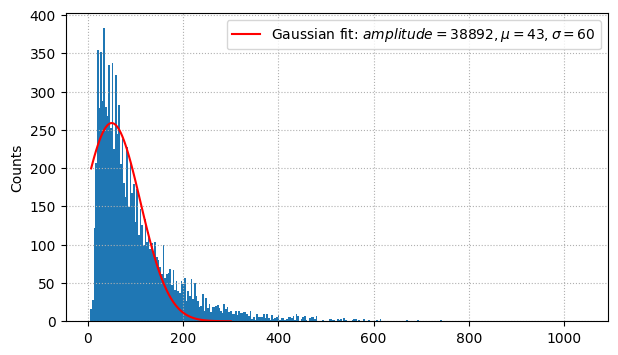

In [83]:
binscenters = np.array([0.5 * (edges1[i] + edges1[i+1])  for i in range(len(edges1)-1)])
# print(binscenters)

x1 = []
y1 = []
for i in range(len(edges1)):
    if (edges1[i] > 0) and (edges1[i] < 300):
        y1.append(counts1[i])
        x1.append(binscenters[i])

popt, pcov = curve_fit(GaussianFit, x1-x1[0],y1)
fig1, ax1 = plt.subplots(1,1,figsize=(7,4))

(counts1,edges1, patches1) = plt.hist(review_length, bins)

# fig2, ax2 = plt.subplots(1,1,figsize=(7,4))

plt.plot(x1, GaussianFit(x1-x1[0], *popt), color='red',label= r'Gaussian fit: $amplitude=%5.0f, \mu=%5.0f, \sigma=%5.0f$' % tuple(popt))

plt.ylabel("Counts")
plt.legend(fontsize=10, loc='upper right')
plt.grid(linestyle=':')
plt.savefig("02.review.length.pdf", format="pdf", bbox_inches="tight") 
plt.show()